### determining neuronal subtype
---
#### 1. define genes 
#### 2. heat map
#### 3. PCA and clustermap(correlation)

In [57]:
# Import Library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [58]:
# Set Config
CONFIG = {
    "data_dir": "./TPM.csv"
    , "genes": ["GLS", "GLS2", "GLUL", "GRIN1", "GRIN2B", "SLC17A7", "SLC17A6"]
    , "color":sns.diverging_palette(255, 10, l=50, s=100, n=40, center="dark")
    , "cbar": {"shrink": 0.8}
    , "adopted_comp": 3
    , "name": "Glutaminergic_neuron_B7"
    , "CMsize": (5, 5)
    , "CMfontsize": 1.5
    , "CMrotation": (90, 0)
    , "CMcolor": sns.diverging_palette(255, 10, l=50, s=100, n=40, center="dark")
    , "CMsc": None
    , "CMdendrosize": (0.1, 0.1)
    , "CMcbarpos": (1.05, 0.15, 0.05, 0.7) 
}

In [59]:
# Load Data
rawdata = pd.read_csv(CONFIG['data_dir'], index_col=0).T

In [60]:
# Shape Data
data = np.log2(rawdata+1).sort_index()
data.index.name=None

In [61]:
# Select genes
df = data.loc[:, CONFIG["genes"]].iloc[9:18, :]
df.columns.name=CONFIG["name"]
df

Glutaminergic_neuron_B7,GLS,GLS2,GLUL,GRIN1,GRIN2B,SLC17A7,SLC17A6
B7_C34,3.078739,0.000000e+00,8.553477,0.000000,0.067587,0.000000,0.056233
B7_C34.1,2.635935,3.175835e-01,8.863144,0.023435,0.202906,0.000000,0.028378
B7_C34.2,3.256927,1.375872e-11,8.705595,0.025197,0.097108,0.000000,0.227702
B7_DAPT,3.176103,4.053780e-02,8.504863,0.000000,0.000000,0.000000,0.000000
B7_DAPT.1,3.592786,0.000000e+00,8.625759,0.000000,0.025277,0.000000,0.620191
B7_DAPT.2,3.786900,9.060251e-12,8.535362,0.000000,0.002915,0.000000,0.000000
B7_control,3.344710,0.000000e+00,7.810452,0.266619,0.000000,0.129715,1.523597
B7_control.1,3.057966,0.000000e+00,7.807823,0.326014,0.124934,0.000000,0.000000
B7_control.2,3.055406,0.000000e+00,7.685099,0.000000,0.237530,0.000000,0.791734


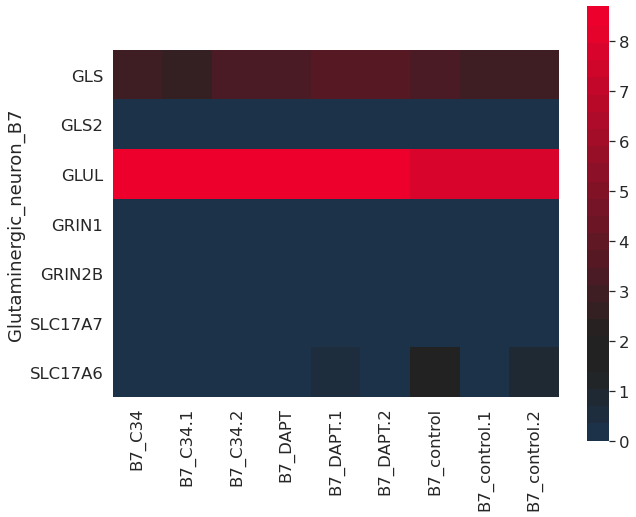

In [62]:
# TPM heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.T, cmap=CONFIG["color"], square=True, robust=True, center=df.mean().mean(), cbar=True, cbar_kws=CONFIG["cbar"])
plt.yticks(rotation=0)
plt.savefig(f"./{CONFIG['name']}_HeatMap_TPM.png", facecolor="white", dpi=300, bbox_inches="tight", pad_inches=0.05)

In [63]:
# PCA
model = PCA(random_state=0)
model.fit(df)
Rdata = pd.DataFrame(model.transform(df), index=df.index, columns=[f"PC{i}"for i in range(1, min(len(df), len(df.T))+1)])

In [64]:
# Contribution
temp = [
[f"{i:.2f}" for i in (model.explained_variance_ratio_ * 100)]
, [f"{i:.2f}" for i in (model.explained_variance_ratio_.cumsum() * 100)]
]

cont = pd.DataFrame(temp
            , index=['contribution [%]', 'cumulative contribution [%]']
            , columns=[f"PC_{i}" for i in range(1, min(len(df), len(df.T))+1)]
).T
cont.to_csv(f"{CONFIG['name']}_contribution.csv", index=True)
cont

,contribution [%],cumulative contribution [%]
PC_1,61.55,61.55
PC_2,21.55,83.09
PC_3,14.26,97.35
PC_4,1.75,99.11
PC_5,0.58,99.69
PC_6,0.29,99.98
PC_7,0.02,100.00


In [65]:
# Save Data as csv.
Pdata = pd.DataFrame(model.transform(df)[:, :CONFIG["adopted_comp"]]
                       , columns=[f"PC{i}"for i in range(1, CONFIG["adopted_comp"]+1)]
                       , index=df.index
                      )
Pdata.to_csv(f"{CONFIG['name']}_stemness_PCAed_data_n={CONFIG['adopted_comp']}.csv", index=True)

[Text(0, 0.5, 'PC2(21.545%)'), Text(0.5, 0, 'PC1(61.55%)')]

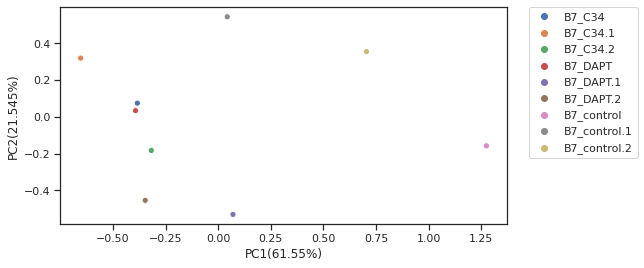

In [66]:
# Plot
sns.set() 
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (8,4))
[pc1, pc2] = model.explained_variance_ratio_[0:2]
PC1 = round(100*pc1, 3)
PC2 = round(100*pc2, 3)
sns.scatterplot(x="PC1", y="PC2", data=Pdata, hue=Pdata.index)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel=f"PC1({PC1}%)",ylabel=f"PC2({PC2}%)")

In [67]:
# Correlation
cor = Pdata.T.corr()
cor.columns.name=CONFIG["name"]

<Figure size 360x360 with 0 Axes>

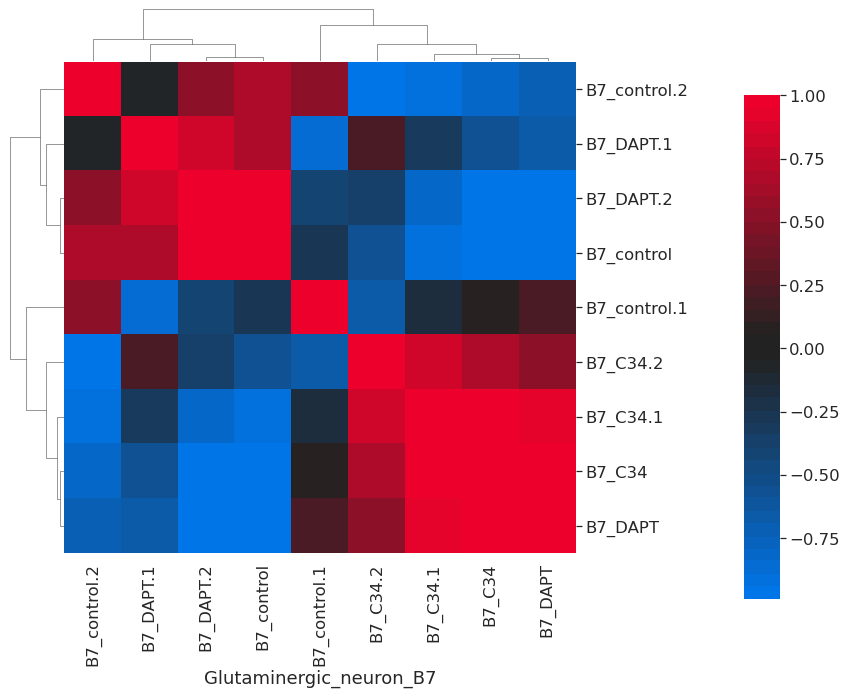

In [68]:
# Cluster Map
plt.figure(figsize=CONFIG["CMsize"])
sns.set(font_scale=CONFIG["CMfontsize"])
CM = sns.clustermap(cor
               , cmap=CONFIG["CMcolor"]
               , robust=True
               , center=cor.mean().mean()
               , row_colors=CONFIG["CMsc"]
               , col_colors=CONFIG["CMsc"]
               , dendrogram_ratio=CONFIG["CMdendrosize"]
               , cbar_pos=CONFIG["CMcbarpos"]
              )
plt.setp(CM.ax_heatmap.get_xticklabels(), rotation=CONFIG["CMrotation"][0])
plt.setp(CM.ax_heatmap.get_yticklabels(), rotation=CONFIG["CMrotation"][1])
plt.savefig(f"./{CONFIG['name']}_PCAed_ClusterMap_n={CONFIG['adopted_comp']}.png", facecolor="white", dpi=300, bbox_inches="tight", pad_inches=0.05)